# **Lab 2: Exploring Image Data**
**Name(s):** Luke Voinov, Tiffany Nguyen

## **1. Business Understanding**
[2 points] Give an overview of the dataset. Describe the purpose of the data set you selected (i.e., why was this data collected in the first place?). What is the prediction task for your dataset and which third parties would be interested in the results? Why is this data important? Once you begin modeling, how well would your prediction algorithm need to perform to be considered useful to the identified third parties? Be specific and use your own words to describe the aspects of the data. 

## **2. Data Preparation** 


### **2.1.1 As Numpy Arrays**
[.5 points] Read in your images as numpy arrays. Resize and recolor images as necessary.

In [65]:
# 2.1.1 As Numpy Arrays Code below


### **2.1.2 Linearization**
[.4 points] Linearize the images to create a table of 1-D image features (each row should be one image). 

In [66]:
# 2.1.2 Linearization Code Below, we should have output with the images

### **2.1.3 Visualization**
[.1 points] Visualize several images.

In [67]:
# 2.1.3 Visualization, we'll need to figure out what kind of images we need to visualize

## **3. Data Reduction**


### **3.1.1 Linear Dimensionality Reduction with PCA**
[.5 points] Perform linear dimensionality reduction of the images using principal components analysis. Visualize the explained variance of each component. Analyze how many dimensions are required to adequately represent your image data. Explain your analysis and conclusion.

In [68]:
# 3.1.1 Linear Dimensionality Reduction with PCA

### **3.1.2 Linear Dimensionality Reduction with Randomized Principle Components Analysis**
[.5 points] Perform linear dimensionality reduction of your image data using randomized principle components analysis. Visualize the explained variance of each component. Analyze how many dimensions are required to adequately represent your image data. Explain your analysis and conclusion.

In [69]:
# 3.1.2 Linear Dimensionality w Randomized PCA

### **3.1.3 Comparison between dimensionality methods (PCA & Randomized PCA)**
[2 points]  Compare the representation using PCA and Randomized PCA. The method you choose to compare dimensionality methods should quantitatively explain which method is better at representing the images with fewer components.  Do you prefer one method over another? Why?

[ Answer here ]

### **3.2.1 Feature Extraction**

Let's apply feature extraction using an implementation of DAISY. We chose DAISY due to its ability to efficiently capture dense, localized image descriptors. It is well-suited for tasks requiring scale and rotation invariance, making it ideal for applications involving image matching or object recognition. In our case, we are using object recognition to recognize what chess pieces are on the board (the images we are using). It further enhances its suitability for extracting meaningful features from visual data.

Daisy works by computing a dense grid of descriptors across the image. where each descriptor is based on histograms of gradient orientations within a circular region. These regions are divided into concentric rings, and the histograms are weighted by Gaussian kernels to emphasize the center. The structure ensures that the descriptors are robust to variations in scale, rotation, and lighting, while maintaining computational efficiency.

In [70]:
# MOVE THIS WHEN WE ARE FINISHED FORMATTING, USED FOR FEATURE EXTRACTION SECTION
import os
import pandas as pd

source_dir = r"/Users/tiffany/Desktop/CS 5324/Lab 2/Images"

filepaths=[]
filelist=os.listdir(source_dir)
for f in filelist:
    fpath = os.path.normpath(os.path.join(source_dir, f))
    filepaths.append(fpath)
Fseries=pd.Series(filepaths, name='filepaths')
df=pd.concat([Fseries], axis=1)

df.info

<bound method DataFrame.info of                                               filepaths
0     /Users/tiffany/Desktop/CS 5324/Lab 2/Images/R7...
1     /Users/tiffany/Desktop/CS 5324/Lab 2/Images/rK...
2     /Users/tiffany/Desktop/CS 5324/Lab 2/Images/r3...
3     /Users/tiffany/Desktop/CS 5324/Lab 2/Images/R4...
4     /Users/tiffany/Desktop/CS 5324/Lab 2/Images/R6...
...                                                 ...
1995  /Users/tiffany/Desktop/CS 5324/Lab 2/Images/r7...
1996  /Users/tiffany/Desktop/CS 5324/Lab 2/Images/R6...
1997  /Users/tiffany/Desktop/CS 5324/Lab 2/Images/r5...
1998  /Users/tiffany/Desktop/CS 5324/Lab 2/Images/r7...
1999  /Users/tiffany/Desktop/CS 5324/Lab 2/Images/R7...

[2000 rows x 1 columns]>

In [71]:
# MOVE THIS WHEN WE ARE FINISHED FORMATTING, USED FOR FEATURE EXTRACTION
#
# Code adapted from github Coilot to reduce the pixel size from 400x400 to 64x64

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import time

print(f"Processing {len(df)} chess images...")
start_time = time.time()

# Get image dimensions from first image
first_img = plt.imread(df.iloc[0]['filepaths'])
print(f"Original image size: {first_img.shape}")

# High-quality resolution with 2K images (224x224 for excellent detail)
target_size = (224, 224)  # High quality - can see individual chess pieces clearly
print(f"Downsampling to: {target_size}")

# Limit to 2000 images for better quality/memory balance
n_samples = min(2000, len(df))
n_features = target_size[0] * target_size[1]
memory_estimate_gb = (n_samples * n_features * 4) / (1024**3)

df_subset = df.iloc[:n_samples].copy()
X = np.zeros((len(df_subset), n_features), dtype=np.float32)

# Process images in batches
batch_size = 100
for batch_start in range(0, len(df_subset), batch_size):
    batch_end = min(batch_start + batch_size, len(df_subset))
    
    for i in range(batch_start, batch_end):
        img = plt.imread(df_subset.iloc[i]['filepaths'])
        
        # Convert to grayscale if color image
        if len(img.shape) == 3:
            img = np.mean(img, axis=2)
        
        # Resize image using PIL
        img_pil = Image.fromarray((img * 255).astype(np.uint8) if img.max() <= 1 else img.astype(np.uint8))
        img_resized = img_pil.resize(target_size, Image.Resampling.LANCZOS)
        img_array = np.array(img_resized, dtype=np.float32) / 255.0
        
        X[i] = img_array.flatten()

h, w = target_size  # Set dimensions for later use
end_time = time.time()
print(f"\nProcessing completed in {end_time - start_time:.2f} seconds")
print(f"Dataset shape: {X.shape}")

Processing 2000 chess images...
Original image size: (400, 400, 3)
Downsampling to: (224, 224)

Processing completed in 7.41 seconds
Dataset shape: (2000, 50176)


Let's prepare our images for DAISY implementation. 

In [72]:
# Code borrowed by Eric Larson, 04. Dimension Reduction and Images

idx_to_reconstruct = int(np.random.rand(1)*len(X)) # Randomly selecting an image from our data set
img  = X[idx_to_reconstruct].reshape((h,w)) # Reshaping the selected image to its original dimensions

/var/folders/07/1_cm7qnd2mg18rts7n3nf9hw0000gn/T/ipykernel_39950/4057935006.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  idx_to_reconstruct = int(np.random.rand(1)*len(X)) # Randomly selecting an image from our data set


/var/folders/07/1_cm7qnd2mg18rts7n3nf9hw0000gn/T/ipykernel_39950/2598489095.py:13: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  imshow(img_desc)


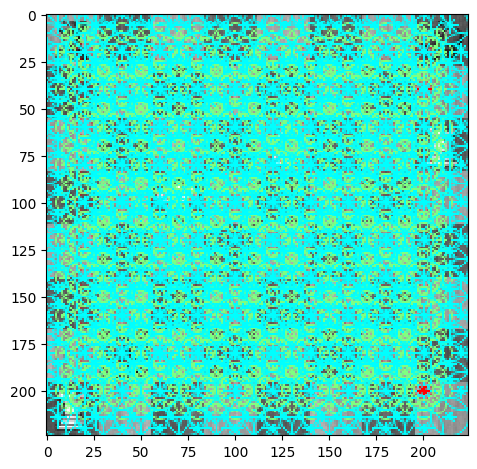

In [73]:
# Code borrowed by Eric Larson, 04. Dimension Reduction and Images

from skimage.feature import daisy

# lets first visualize what the daisy descriptor looks like
features, img_desc = daisy(img, 
                           step=20, 
                           radius=20, 
                           rings=2, 
                           histograms=8, 
                           orientations=8, 
                           visualize=True)
imshow(img_desc)
plt.grid(False)
plt.show()

We can see that the chessboard has a highly repetitive high-contrast grid, hence why DAISY extracts the dense gradient orientation histograms across circular regions. The pieces create some irregularities in the pattern, but they're drowned out visually due to the grid.

In [74]:
from skimage.feature import daisy
from skimage.transform import resize
import numpy as np

# Resize all images to a consistent shape (e.g., 64x64)
target_shape = (64, 64)
images_resized = np.array([resize(img, target_shape) for img in images])

# Compute DAISY features for all resized images
daisy_feature_imgs = np.array(
    [daisy(row, step=20, radius=20, rings=2, histograms=8, orientations=8, visualize=False).flatten() for row in images_resized]
)

# Debugging: Print original and post-DAISY feature shapes
print("----- Daisy Feature Extraction Summary -----")
print(f"Original shape: {images_resized.shape}")
print(f"Original number of features: {images_resized.shape[1] * images_resized.shape[2]}")

print(f"Post Daisy shape: {daisy_feature_imgs.shape}")
print(f"Post-Daisy number of features: {daisy_feature_imgs.shape[1]}")

----- Daisy Feature Extraction Summary -----
Original shape: (1288, 64, 64)
Original number of features: 4096
Post Daisy shape: (1288, 544)
Post-Daisy number of features: 544


The summary shows how the DAISY descriptor reduces or transforms the raw pixel data into a more compact and meaningful feature representation. We can see that it reduced from 4096 raw pixel values to 544 meaningful features per image.

/var/folders/07/1_cm7qnd2mg18rts7n3nf9hw0000gn/T/ipykernel_39950/1192969656.py:15: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  imshow(X[idx1].reshape((h,w)))
/var/folders/07/1_cm7qnd2mg18rts7n3nf9hw0000gn/T/ipykernel_39950/1192969656.py:20: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  imshow(X[idx2].reshape((h,w)))


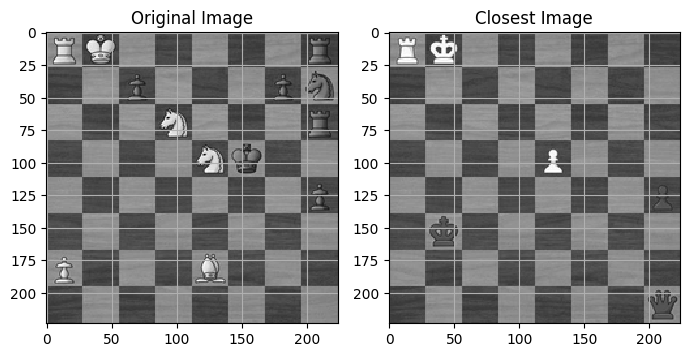

In [82]:
# Code borrowed by Eric Larson, 04. Dimension Reduction and Images

import copy

dist_matrix = pairwise_distances(X, metric='euclidean') # Adapted from Copilot to figure out metric

# find closest image to current image
idx1 = 5
distances = copy.deepcopy(dist_matrix[idx1,:])
distances[idx1] = np.infty # dont pick the same image!
idx2 = np.argmin(distances)

plt.figure(figsize=(7,10))
plt.subplot(1,2,1)
imshow(X[idx1].reshape((h,w)))
plt.title("Original Image")
plt.grid()

plt.subplot(1,2,2)
imshow(X[idx2].reshape((h,w)))
plt.title("Closest Image")
plt.grid()

Above you can see that the closet image to the original image has the same positions for both for the Rook and the King. The Rook being in the top left is the most important feature, hence the "closest image" matches with this.

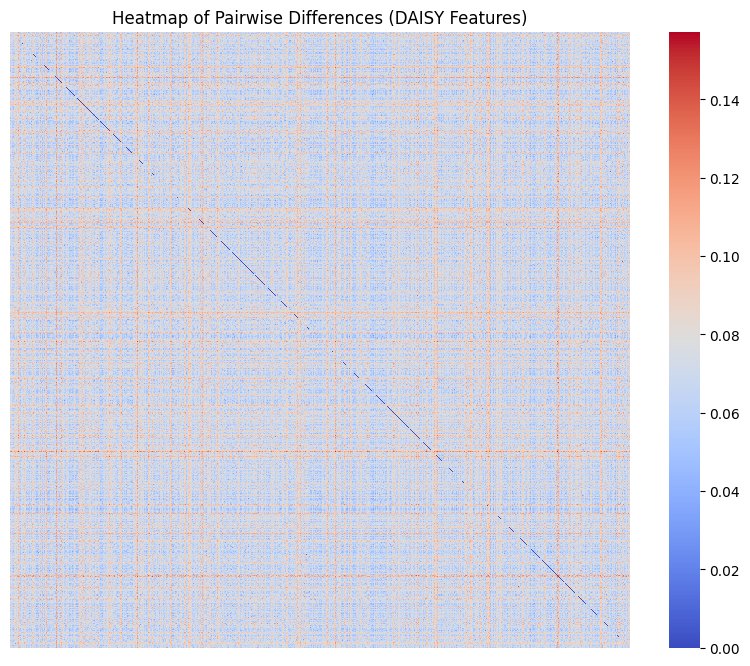

In [81]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import pairwise_distances

# Compute pairwise distances
daisy_features = daisy_feature_imgs
dist_matrix = pairwise_distances(daisy_features)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(dist_matrix, cmap='coolwarm', xticklabels=False, yticklabels=False)
plt.title('Heatmap of Pairwise Differences (DAISY Features)')
plt.show()

The strong vertical and horizontal grid lines mean that many descriptors are nearly identifical, producing large rectangular blocks. We can expect this due to the repetitive pattern of a chessboard. All the empty square with the same gradient pattern yield very similar DAISY descriptors, so the pairwise differences are small (indicated as blue in the heatmap). When one row/column is very different, you can see there's a stripe of higher differences intersecting others.

Squares with pieces will from "hot" differences relative to the empty square. If a square contains a piece, its descriptor will be intermediate, making it less clustered. With our DAISY descriptors that we implemented, it captured the board's repetitive structure but also detect the pieces on the board.

### **3.2.2 Feature Extraction for Prediction Task**
[2 points] Does this feature extraction method show promise for your prediction task? Why? Use visualizations to analyze this questions. For example, visualize the differences between statistics of extracted features in each target class. Another option, use a heat map of the pairwise differences (ordered by class) among all extracted features. Another option, build a nearest neighbor classifier to see actual classification performance.  

In [21]:
# Show visualizations to analyze the question

[ Answer to the actual question and elaborating what our visualizations mean and backing up our reason if yes or no ]

## **4. Exceptional Work**
[1 point] One idea (required for 7000 level students): Perform feature extraction upon the images using DAISY. Rather than using matching on the images with the total DAISY vector, you will instead use key point matching. You will need to investigate appropriate methods for key point matching using DAISY. NOTE: this often requires some type of brute force matching per pair of images, which can be computationally expensive. Does it perform better than not using key point matching? 

In [22]:
# Code for Exceptional Work